In [1]:
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import os, sys, traceback
import cPickle as pickle

%matplotlib inline
import matplotlib.pylab as plt

The goal of this notebook is to verify that the correlation birth proposal is generating reasonable template parameters (atime and perhaps amplitude). 

First we consider the case where we're proposing against a blank signal.

In [2]:
# set up an appropriate SG
from sigvisa.infer.event_birthdeath import ev_birth_move_correlation

def setup(init_ev=False):
    stas = ["PDAR",]
    evid = 877774
    wiggle_family="db4_2.0_3_20.0"
    uatemplate_rate = 4e-4
    phases = ["P", ]

    rs = EventRunSpec(evids=[evid,],
                      stas=stas,
                      runids=(8,6),
                      pre_s = 50,
                      post_s = 300,
                      force_event_wn_matching=False,
                      initialize_events=init_ev)

    ms = ModelSpec(template_model_type="gpparam",
                    wiggle_family=wiggle_family,
                    wiggle_model_type="gp_lld",
                    uatemplate_rate=uatemplate_rate,
                    max_hz=10.0,
                    phases=phases,
                    dummy_fallback=True,
                    raw_signals=True,
                    vert_only=True)

    ms.add_inference_round(enable_event_moves=True, enable_event_openworld=True,
                            enable_template_openworld=True, enable_template_moves=True, steps=500)

    sg = rs.build_sg(ms)
    initialize_sg(sg, ms, rs)
    wn = sg.station_waves["PD31"][0]

    nm = wn.nm_node.get_value()
    nm.em.std = 20.0
    nm = wn.nm_node.set_value(nm)
    
    sg.debug_dists = {}
    sg.debug_dists[wn.label] = {}
    
    sg.current_log_p()
    
    return sg, wn

# plot the initial state
def plot_state(wn, plot_wave=True):
    f = plt.figure(figsize=(12, 5))
    ax = f.add_subplot(111)
    wn.plot(ax=ax, plot_pred=True, model_lw=None, ev_lw=None, 
            plot_wave=plot_wave, plot_stddev=True, wave_alpha=0.3)
    ax.set_xlim([1174079265, 1174079290])
    

sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;hz_10.0, fraction_valid: 0.897435897436, npts: 3900, srate: 10.0, valid_len: 350.0


select model_fname, model_type from sigvisa_param_model where param='armean' and site='PD31' and phase='noise_raw' and chan='BHZ' and band='freq_0.8_4.5' and (fitting_runid=8 or fitting_runid=6)


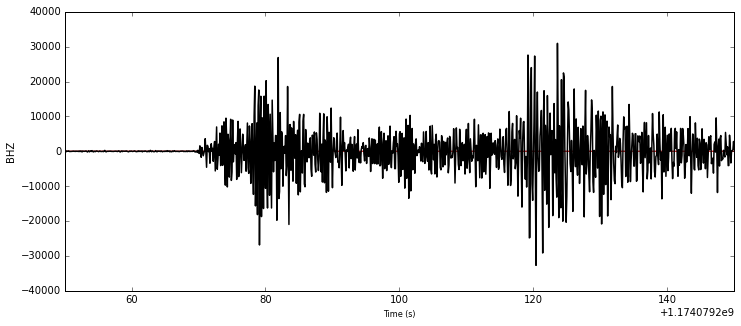

In [3]:
sg, wn = setup(init_ev=False)
plot_state(wn)

In [4]:
#print wn.get_template_params_for_arrival(1, "P")

In [5]:
# run a correlation

ev_birth_move_correlation(sg)

/home/dmoore/python/sigvisa/infer/correlations/weighted_event_posterior.py:45: RuntimeWarning: divide by zero encountered in log
  origin_ll = np.log(rr) + llmax
/home/dmoore/python/sigvisa/infer/correlations/event_proposal.py:129: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf[idx])
/home/dmoore/python/sigvisa/models/signal_model.py:596: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)
/home/dmoore/python/sigvisa/infer/event_birthdeath.py:475: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  tssm = TransientCombinedSSM(components, 1e-6)


proposal using correlation True


True

({'coda_height': 9.69636068502873, 'arrival_time': 1174079269.8743181, 'coda_decay': -6.409029692816636, 'peak_decay': -1.5822396747342289, 'peak_offset': 0.3361236762394586}, <sigvisa.models.templates.lin_polyexp.LinPolyExpTemplateGenerator object at 0x7f13a588b950>)


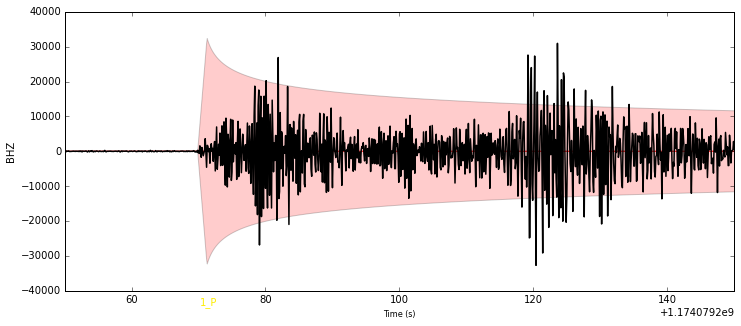

In [6]:
print wn.get_template_params_for_arrival(1, "P")
plot_state(wn)

# Debugging atime proposals

Here I'm going to step inside the proposal steps for this case.

sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;hz_10.0, fraction_valid: 0.897435897436, npts: 3900, srate: 10.0, valid_len: 350.0


select model_fname, model_type from sigvisa_param_model where param='armean' and site='PD31' and phase='noise_raw' and chan='BHZ' and band='freq_0.8_4.5' and (fitting_runid=8 or fitting_runid=6)


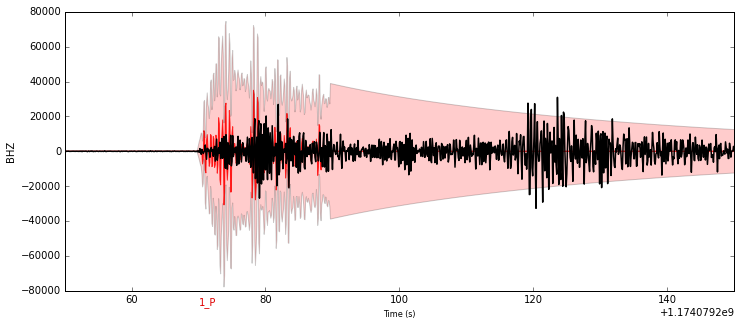

In [7]:
sg, wn = setup(init_ev=True)
plot_state(wn, plot_wave=True)

In [8]:
eid = 1
phase = "P"
tmvals, _ = wn.get_template_params_for_arrival(eid, phase)
pbu = wn.unexplained_kalman(exclude_eids=[eid,])


from sigvisa.infer.event_birthdeath import correlation_atime_ll
atime_ll = correlation_atime_ll(sg, wn, tmvals, eid, phase, pbu)

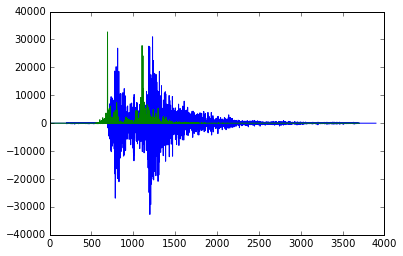

In [9]:
plt.plot(pbu)

scale = np.max(np.abs(pbu))
plt.plot(atime_ll / np.max(atime_ll) * scale, color="green")

(500, 1000)

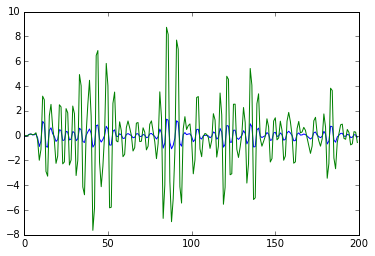

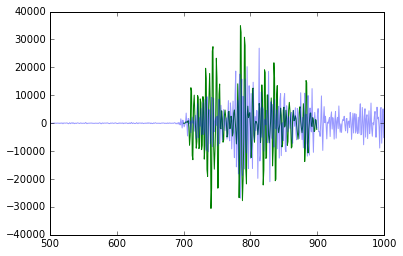

In [13]:
plt.plot(sg.debug_dists[wn.label]["pred_wavelet"])
plt.plot(sg.debug_dists[wn.label]["pred_signal"]  / 4000)
plt.figure()
plt.plot(np.arange(700, 900), sg.debug_dists[wn.label]["pred_signal"] , color="green")
plt.plot(pbu, color="blue", alpha=0.4)
plt.xlim(500, 1000)

(ORIGINAL) CONCLUSION: I'm getting bad atime proposals because I'm correlating a predicted signal whose shape does not match up well with the original fit template. This is only going to fixed by using a GP template model. 

# Proposals with existing uatemplates

sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;hz_10.0, fraction_valid: 0.897435897436, npts: 3900, srate: 10.0, valid_len: 350.0


select model_fname, model_type from sigvisa_param_model where param='armean' and site='PD31' and phase='noise_raw' and chan='BHZ' and band='freq_0.8_4.5' and (fitting_runid=8 or fitting_runid=6)
birthed True
plotting uatemplate -1 as color (0.0, 0.86470588235294121, 0.99620493358633777, 1.0)


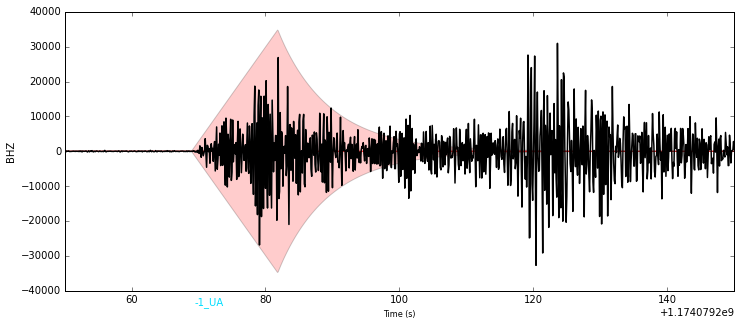

In [6]:
np.random.seed(1)
sg, wn = setup(init_ev=False)

from sigvisa.infer.template_mcmc import optimizing_birth_move
birthed = optimizing_birth_move(sg, wn)
print "birthed", birthed

plot_state(wn, plot_wave=True)

In [7]:
import logging
sg.logger.setLevel(logging.DEBUG)
ev_birth_move_correlation(sg)


> /home/dmoore/python/sigvisa/infer/event_birthdeath.py(164)ev_phase_template_logprob()
-> if return_debug:
(Pdb) list
159  	            print "%s lp %s=%.2f is %.2f" % (wn.sta, param, val, lp_param)
160  	        lp += lp_param
161  	
162  	    import pdb; pdb.set_trace()
163  	
164  ->	    if return_debug:
165  	        return lp, lps
166  	    else:
167  	        return lp
168  	
169  	def joint_association_distribution(sg, wn, eid, phases, associate_using_mb=True, max_ttr=25.0):
(Pdb) print lp
[-6.93210469]
(Pdb) continue


DEBUG:sigvisa:odds for P 1 are [ 1708.91323394]


> /home/dmoore/python/sigvisa/infer/event_birthdeath.py(196)joint_association_distribution()
-> joint_dist.normalize()
(Pdb) continue


DEBUG:sigvisa:using assoc [('P', 1)] with lp -0.000585 (dist {(None,): 0.00058482499588352079, (1,): 0.99941517500411647})
DEBUG:sigvisa:proposing to deassociate P at PD31 (lp -0.0)
INFO:sigvisa:birth move acceptance 38.708748 from old -10286592.006767 new -10286551.054568 lqb -0.002470 lqf 2.240981


True

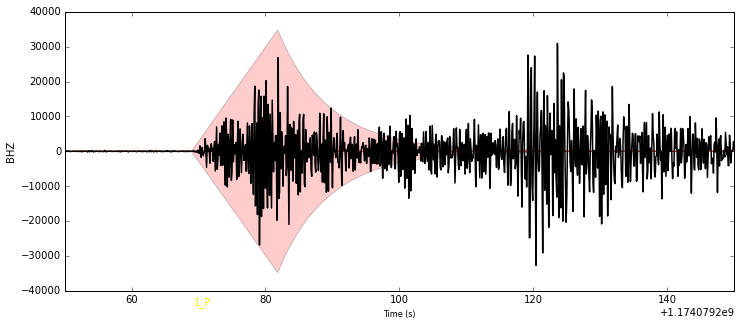

In [8]:
plot_state(wn, plot_wave=True)

In [11]:
sg.debug_dists[wn.label].keys()

[]

# Location stickiness

sta: PD31, chan BHZ. filter_str: ;freq_0.8_4.5;hz_10.0, fraction_valid: 0.897435897436, npts: 3900, srate: 10.0, valid_len: 350.0


select model_fname, model_type from sigvisa_param_model where param='armean' and site='PD31' and phase='noise_raw' and chan='BHZ' and band='freq_0.8_4.5' and (fitting_runid=8 or fitting_runid=6)


/home/dmoore/python/sigvisa/models/signal_model.py:596: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


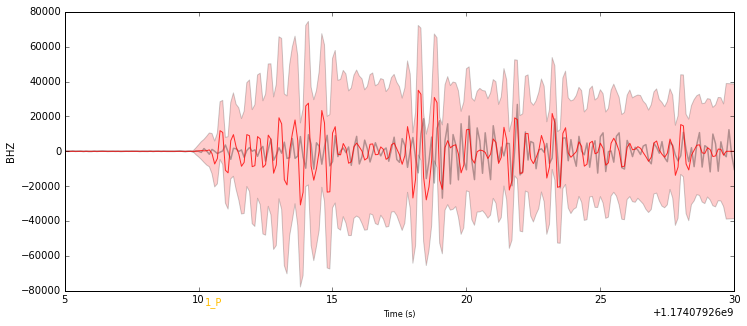

In [3]:
np.random.seed(1)
sg, wn = setup(init_ev=True)
plot_state(wn, plot_wave=True)


In [7]:
eid = 1
phase="P"
tmnodes = sg.get_template_nodes(sta=wn.sta, chan=wn.chan, band=wn.band, eid=eid, phase=phase)

from sigvisa.infer.template_xc import atime_xc_move, xc_move
current_atime, proposed_atime, log_qforward, log_qbackward, k_atime, n_atime, relevant_nodes, source_v = xc_move(sg, wn, eid, phase, tmnodes)


ValueError: a must be non-empty

In [6]:
from sigvisa.infer.mcmc_logger import MCMCLogger
from sigvisa.infer.run_mcmc import run_open_world_MH
logger = MCMCLogger()

run_open_world_MH(sg, steps=50,
                      enable_event_openworld=False,
                      enable_event_moves=False,
                      enable_phase_openworld=False,
                      enable_template_openworld=False,
                      enable_template_moves=True,
                      enable_hparam_moves=False,
                      template_move_type="rw", 
                      logger=logger)

"""
run_open_world_MH(sg, steps=10000,
                      enable_event_openworld=False,
                      enable_event_moves=True,
                      enable_phase_openworld=False,
                      enable_template_openworld=False,
                      enable_template_moves=True,
                      enable_hparam_moves=False,
                      template_move_type="rw", 
                      logger=logger)
"""

step 1: lp -239705.80, accepted arnoise_params: 1.000%, arrival_time: 0.000%, arrival_time_big: 0.000%, coda_decay: 0.000%, coda_height: 0.500%, coda_height_small: 0.500%, ev_source_type: 1.000%, indep_peak: 0.000%, peak_decay: 0.000%, peak_offset: 0.250%, swap_association: 0.000%, , uatemplates: 0 , events: 1 
a must be non-empty
a must be non-empty
saving debug dump to /home/dmoore/python/sigvisa/logs/mcmc/00868/step_000041...
saved pickled graph
a must be non-empty
step 43: lp -31910.47, accepted arnoise_mean: 0.091%, arnoise_params: 0.600%, arnoise_std: 0.286%, arrival_time: 0.068%, arrival_time_big: 0.000%, atime_xc: 0.000%, coda_decay: 0.023%, coda_height: 0.045%, coda_height_small: 0.250%, ev_source_type: 0.045%, indep_peak: 0.000%, peak_decay: 0.023%, peak_offset: 0.170%, swap_association: 0.000%, , uatemplates: 0 , events: 1 
a must be non-empty


'\nrun_open_world_MH(sg, steps=10000,\n                      enable_event_openworld=False,\n                      enable_event_moves=True,\n                      enable_phase_openworld=False,\n                      enable_template_openworld=False,\n                      enable_template_moves=True,\n                      enable_hparam_moves=False,\n                      template_move_type="rw", \n                      logger=logger)\n'

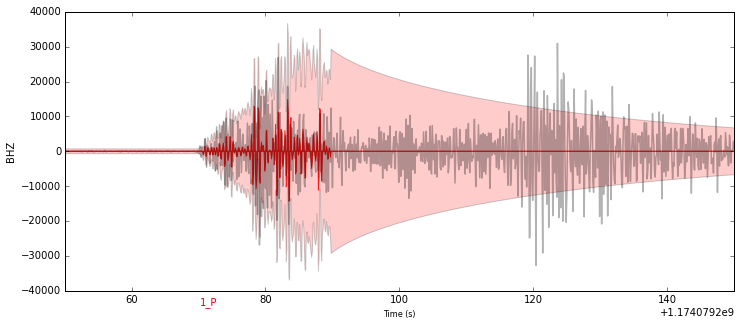

In [7]:
plot_state(wn, plot_wave=True)